## Replication of http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture16.pdf, slide 11

**Result**: behavior is only present after network has been trained

This notebook is currently not runnable due to changes in utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from resnet import *
from vgg import *

from utils import *

gpu_dtype = torch.cuda.FloatTensor

In [2]:
model = ResNet18()
# model = VGG('VGG11')
model.cuda()

for param in model.parameters():
    param.requires_grad = False
print(get_param_count(model))

loader_train, loader_val, loader_test = get_cifar_loaders()

11173962
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Interpolation before training

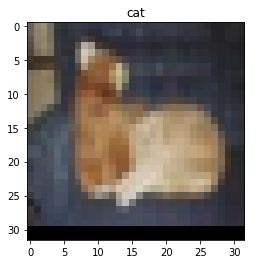

In [3]:
images, labels = iter(loader_train).next()
i = 17
image, label = images[i, np.newaxis], labels[i]

img = image.cuda()
img_var = Variable(img, requires_grad=True)
interpolator = Interpolator(model, img_var)

imshow(img.cpu().numpy(), label)

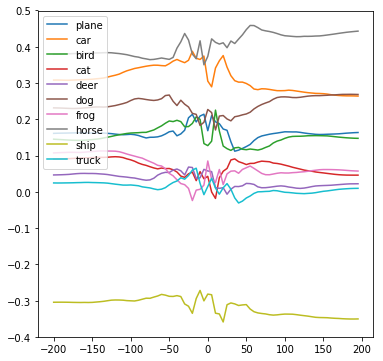

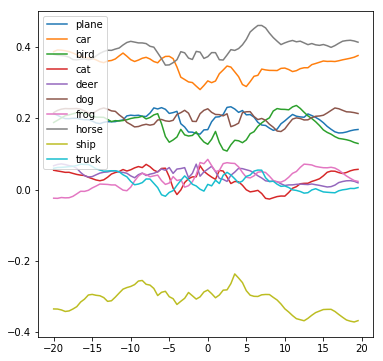

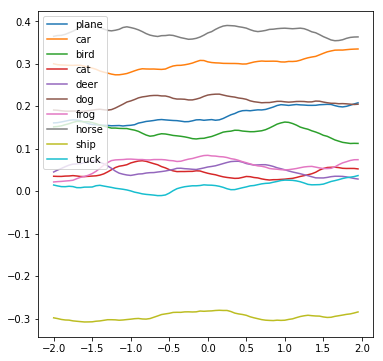

In [4]:
# random direction
g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))

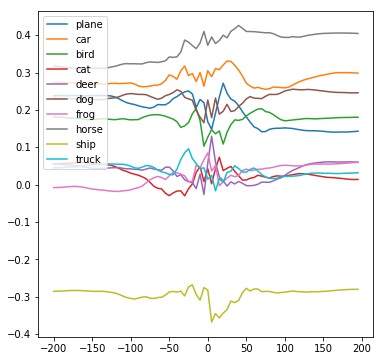

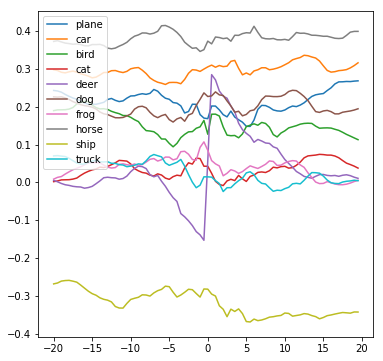

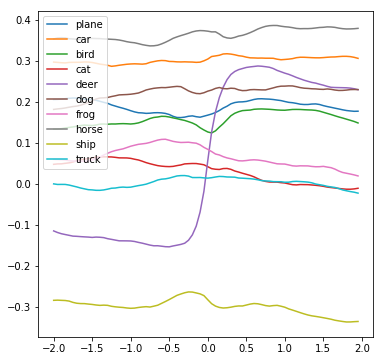

In [5]:
# find adversarial direction
scores = model(img_var)
objective = scores.squeeze()[4]
objective.backward()
g = img_var.grad.data.clone()
img_var.grad.zero_()
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))

## Train the network (resnet18)

In [6]:
for p in model.parameters():
    p.requires_grad = True
model.train()
train(model, loader_train, loader_val, schedule_epochs=[10, 5, 2])

Training for 10 epochs with learning rate 0.100000
Got 551 / 5000 correct (11.02)
Starting epoch 1 / 10
t = 100, loss = 1.9579
t = 200, loss = 1.5556
t = 300, loss = 1.4828
Got 2511 / 5000 correct (50.22)
Starting epoch 2 / 10
t = 100, loss = 1.2632
t = 200, loss = 1.0541
t = 300, loss = 1.0780
Got 3098 / 5000 correct (61.96)
Starting epoch 3 / 10
t = 100, loss = 1.0264
t = 200, loss = 0.8054
t = 300, loss = 0.7878
Got 3396 / 5000 correct (67.92)
Starting epoch 4 / 10
t = 100, loss = 0.8644
t = 200, loss = 0.7636
t = 300, loss = 0.6973
Got 3137 / 5000 correct (62.74)
Starting epoch 5 / 10
t = 100, loss = 0.7469
t = 200, loss = 0.7160
t = 300, loss = 0.6356
Got 2944 / 5000 correct (58.88)
Starting epoch 6 / 10
t = 100, loss = 0.7417
t = 200, loss = 0.6895
t = 300, loss = 0.5944
Got 3067 / 5000 correct (61.34)
Starting epoch 7 / 10
t = 100, loss = 0.5681
t = 200, loss = 0.7203
t = 300, loss = 0.5744
Got 3478 / 5000 correct (69.56)
Starting epoch 8 / 10
t = 100, loss = 0.5911
t = 200, los

In [7]:
check_accuracy(model, loader_test)

Got 9041 / 10000 correct (90.41)


# Run the same experiments on trained network

Now that's what I call generalization

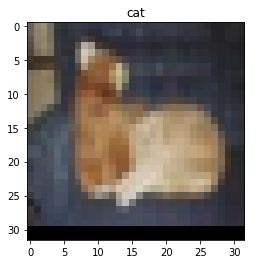

cat
cat


In [8]:
for param in model.parameters():
    param.requires_grad = False

imshow(image, label)
print(CIFAR_CLASSES[labels[i]])
print(CIFAR_CLASSES[model(img_var).max(1)[1].data[0]])

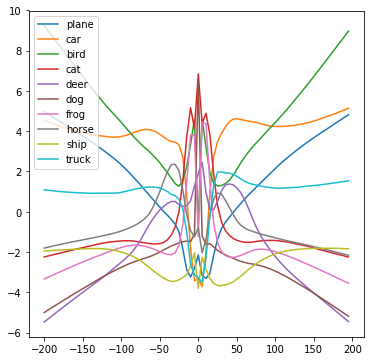

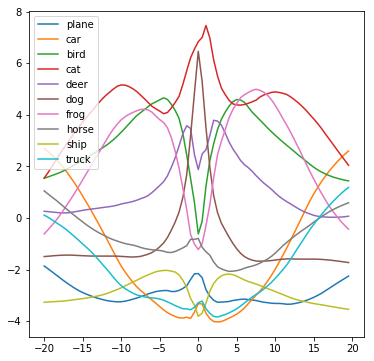

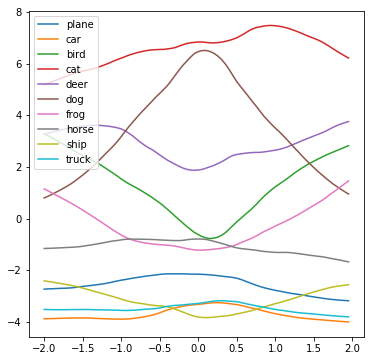

In [9]:
# random direction
g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))

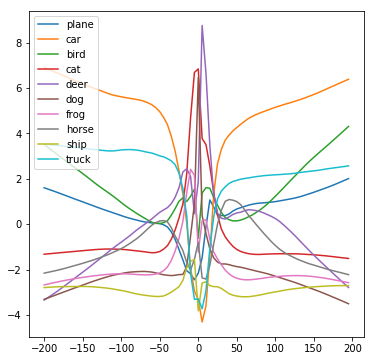

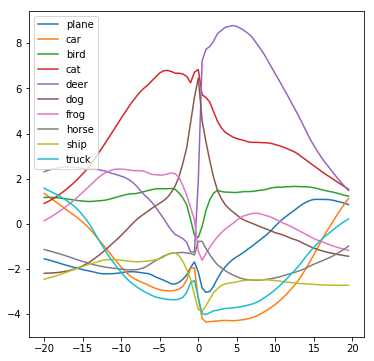

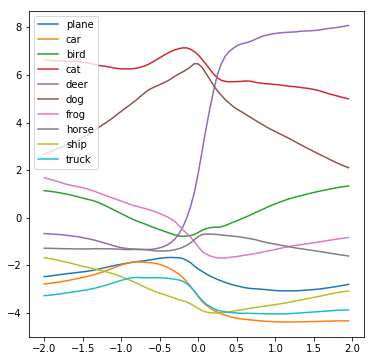

In [10]:
# find adversarial direction
scores = model(img_var)
objective = scores.squeeze()[4]
objective.backward()
g = img_var.grad.data.clone()
img_var.grad.zero_()
g = g / g.norm()

interpolator.plot(g, np.arange(-200, 200, 5))
interpolator.plot(g, np.arange(-20, 20, .5))
interpolator.plot(g, np.arange(-2, 2, .05))